# Convolutional Neural Network applied to Transient Detection

We star by reading the data

In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
#pkl_data = np.load("data/HiTS_data.pkl", encoding='bytes')
pkl_data = np.load(gzip.GzipFile("all_chunks/chunk_188_5000.pkl.gz", 'rb'), encoding='bytes')
#pkl_data = np.load("/Users/guille/Dropbox/git/Deep-HiTS/data/test_data/chunk_101_5000.pkl")
print(pkl_data.keys())
print(pkl_data[b'diff_images'].shape)

dict_keys([b'SNRs', b'RF_pbbs', b'features', b'temp_images', b'sci_images', b'labels', b'diff_images', b'SNR_images'])
(5030, 441)


Now we arrange the data so Keras can handle it

In [4]:
N_data = pkl_data[b'diff_images'].shape[0]
print(N_data)
X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
             pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
             pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
             pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
X = np.swapaxes(X, 0, 1)

Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
print(X.shape, Y.shape)
print(np.mean(Y[:,0]), np.mean(Y[:,1]))

5030
(5030, 4, 21, 21) (5030, 2)
0.5 0.5


Let's plot a couple of stamps

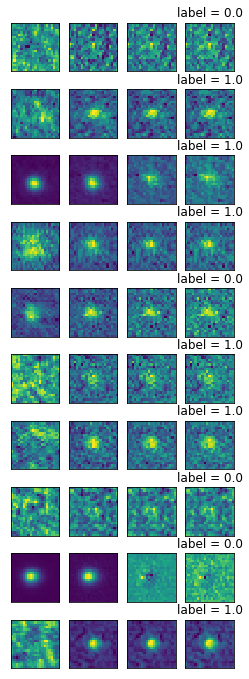

In [28]:
N_plot = 10

plt.clf()
fig, axes = plt.subplots(N_plot, 4, figsize=(4, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(N_plot):
    axes.flat[4*i].imshow(X[i][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X[i][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X[i][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X[i][3], interpolation = "none")
    #axes.flat[4*i + 3].imshow(pkl_data['diff_images'][i].reshape((21, 21)), interpolation = "nearest")

    axes.flat[4*i + 3].set_title ("label = " + str(Y[i][1]))
plt.show()

We split the data into training, and test set.

In [6]:
N_train = int(N_data * 0.9)

X_train, Y_train = X[:N_train], Y[:N_train]
X_test, Y_test = X[N_train:], Y[N_train:]

print("Train: ", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (4527, 4, 21, 21) (4527, 2)
Test:  (503, 4, 21, 21) (503, 2)


We create a Keras sequential model and compile it.

In [7]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

def make_model(compile=True):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    model.add(Convolution2D(32, (4, 4), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        model.compile(loss='mean_squared_error',
              optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        # epochs = 25
        # lrate = 0.01
        # decay = lrate/epochs
        # opt = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

        # # Let's train the model using RMSprop
        # model.compile(loss='mean_squared_error', #categorical_crossentropy',
        #               optimizer=opt,
        #               metrics=['accuracy'])

    return model

Using TensorFlow backend.


In [8]:
model = make_model()

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

Let's plot the model

To get this to plot, need to install (via pip --user or conda):
    
    1. graphviz
    2. pydot-ng

In [ ]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 24, 24)        2080      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 12, 12)        18496     
__________

Now, we fit our model to the training data-set

In [11]:
model.fit(X_train, Y_train, batch_size=32, epochs=25, validation_split=0.2,
         shuffle=True, callbacks=[early_stopping])

Train on 3621 samples, validate on 906 samples
Epoch 1/25
3621/3621 [==============================] - 73s - loss: 0.1096 - acc: 0.8917 - val_loss: 0.0484 - val_acc: 0.9603
Epoch 2/25
3621/3621 [==============================] - 1s - loss: 0.0479 - acc: 0.9533 - val_loss: 0.0414 - val_acc: 0.9625
Epoch 3/25
3621/3621 [==============================] - 1s - loss: 0.0367 - acc: 0.9630 - val_loss: 0.0881 - val_acc: 0.8609
Epoch 4/25
3621/3621 [==============================] - 1s - loss: 0.0273 - acc: 0.9707 - val_loss: 0.0214 - val_acc: 0.9779
Epoch 5/25
3621/3621 [==============================] - 1s - loss: 0.0258 - acc: 0.9729 - val_loss: 0.0167 - val_acc: 0.9834
Epoch 6/25
3621/3621 [==============================] - 1s - loss: 0.0244 - acc: 0.9732 - val_loss: 0.0195 - val_acc: 0.9779
Epoch 7/25
3621/3621 [==============================] - 1s - loss: 0.0215 - acc: 0.9771 - val_loss: 0.0136 - val_acc: 0.9845
Epoch 8/25
3621/3621 [==============================] - 1s - loss: 0.0202 - a

In [12]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

448/503 [=========================>....] - ETA: 0sTest loss: 0.0377265774079
Test accuracy: 0.960238568588


In [13]:
from sklearn import metrics
pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

503/503 [==============================] - 0s     
             precision    recall  f1-score   support

          0       0.93      0.99      0.96       256
          1       0.99      0.93      0.96       247

avg / total       0.96      0.96      0.96       503



Now, lets plot the ones that it got wrong.

In [14]:
ypred = pred
ytest = Y_test[:, 1].astype(int)

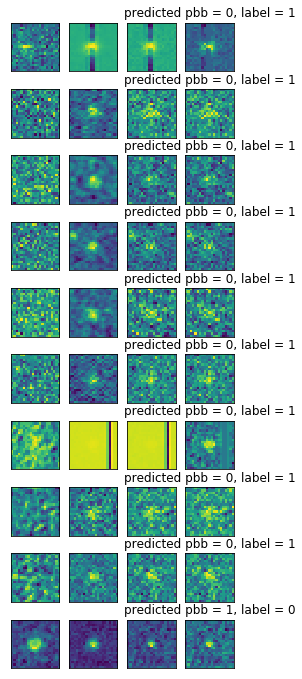

In [15]:
N_plot = 10
only_plot_wrong = True
if not only_plot_wrong:
    plot_inds = range(N_plot)
else:
    plot_inds = np.where(ypred != ytest)[0]
    if len(plot_inds) > N_plot:
        plot_inds = plot_inds[:N_plot]
N_plot = len(plot_inds)

plt.clf()
fig, axes = plt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                        subplot_kw={'xticks': [], 'yticks': []})
i = 0
for ind in plot_inds:
    axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

    axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                  ", label = " + str(ytest[ind]))
    i += 1
plt.show()

Try again with data augmentation...

First break up data into train/cross-validation/test sets...

TBD: probably want to shuffle the data too.

In [16]:
N_train = int(N_data * 0.72)
N_valid = int(N_data * 0.86)
N_test  = int(N_data * 1.0)

X_train, Y_train = X[:N_train], Y[:N_train]
X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

print("Train: ", X_train.shape, Y_train.shape)
print("Valid: ", X_valid.shape, Y_valid.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (3621, 4, 21, 21) (3621, 2)
Valid:  (704, 4, 21, 21) (704, 2)
Test:  (705, 4, 21, 21) (705, 2)


In [17]:
seed = 666
batch_size = 32
epochs = 25   # Probably want to stop around 75 but now we have auto-stopping

In [18]:
def run_model(model, data_augmentation=True):
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping])
    else:
        print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(X_train)

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping]) 
        
    return model

In [19]:
np.random.seed(seed)
model = make_model()
model = run_model(model, data_augmentation=False)

Not using data augmentation.
Train on 3621 samples, validate on 704 samples
Epoch 1/25
3621/3621 [==============================] - 1s - loss: 0.1102 - acc: 0.8981 - val_loss: 0.0486 - val_acc: 0.9702
Epoch 2/25
3621/3621 [==============================] - 1s - loss: 0.0372 - acc: 0.9633 - val_loss: 0.0267 - val_acc: 0.9773
Epoch 3/25
3621/3621 [==============================] - 1s - loss: 0.0302 - acc: 0.9674 - val_loss: 0.0219 - val_acc: 0.9744
Epoch 4/25
3621/3621 [==============================] - 1s - loss: 0.0266 - acc: 0.9713 - val_loss: 0.0181 - val_acc: 0.9858
Epoch 5/25
3621/3621 [==============================] - 1s - loss: 0.0245 - acc: 0.9735 - val_loss: 0.0167 - val_acc: 0.9858
Epoch 6/25
3621/3621 [==============================] - 1s - loss: 0.0229 - acc: 0.9749 - val_loss: 0.0177 - val_acc: 0.9815
Epoch 7/25
3621/3621 [==============================] - 1s - loss: 0.0222 - acc: 0.9762 - val_loss: 0.0238 - val_acc: 0.9759
Epoch 8/25
3621/3621 [===========================

In [20]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

448/705 [==================>...........] - ETA: 0sTest loss: 0.0181662735519
Test accuracy: 0.980141843972


In [21]:
np.random.seed(seed)
model = make_model()
model = run_model(model, data_augmentation=True)

Using real-time data augmentation.
Epoch 1/25
113/113 [==============================] - 1s - loss: 0.1076 - acc: 0.8985 - val_loss: 0.0567 - val_acc: 0.9489
Epoch 2/25
113/113 [==============================] - 1s - loss: 0.0442 - acc: 0.9550 - val_loss: 0.0238 - val_acc: 0.9787
Epoch 3/25
113/113 [==============================] - 1s - loss: 0.0324 - acc: 0.9642 - val_loss: 0.0227 - val_acc: 0.9830
Epoch 4/25
113/113 [==============================] - 1s - loss: 0.0279 - acc: 0.9696 - val_loss: 0.0183 - val_acc: 0.9844
Epoch 5/25
113/113 [==============================] - 1s - loss: 0.0257 - acc: 0.9706 - val_loss: 0.0159 - val_acc: 0.9858
Epoch 6/25
113/113 [==============================] - 1s - loss: 0.0249 - acc: 0.9732 - val_loss: 0.0144 - val_acc: 0.9858
Epoch 7/25
113/113 [==============================] - 1s - loss: 0.0253 - acc: 0.9715 - val_loss: 0.0165 - val_acc: 0.9830
Epoch 8/25
113/113 [==============================] - 1s - loss: 0.0239 - acc: 0.9743 - val_loss: 0.0156

In [22]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

416/705 [================>.............] - ETA: 0sTest loss: 0.0155876012366
Test accuracy: 0.984397163121


In [23]:
from sklearn import metrics
pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

512/705 [====================>.........] - ETA: 0s             precision    recall  f1-score   support

          0       0.98      0.99      0.98       351
          1       0.99      0.98      0.98       354

avg / total       0.98      0.98      0.98       705



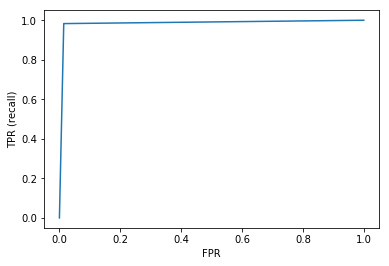

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

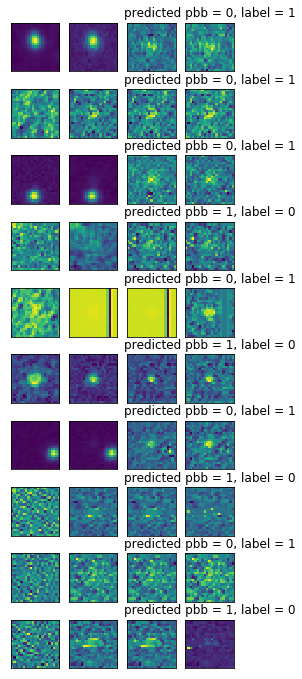

In [24]:
ypred = pred
ytest = Y_test[:, 1].astype(int)

N_plot = 10
only_plot_wrong = True
if not only_plot_wrong:
    plot_inds = range(N_plot)
else:
    plot_inds = np.where(ypred != ytest)[0]
    if len(plot_inds) > N_plot:
        plot_inds = plot_inds[:N_plot]
N_plot = len(plot_inds)

pltt.clf()
fig, axes = pltt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                        subplot_kw={'xticks': [], 'yticks': []})
i = 0
for ind in plot_inds:
    axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

    axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                  ", label = " + str(ytest[ind]))
    i += 1
plt.show()